# Data Cleaning and Preparation

This notebook will read the input dataset and merge the `vpn_customer_data` and `vpn_external_data` into one table `merged_vpn_data` that can be used for most of this analysis.


**Featured libraries:**

1. `pandas`
2. `numpy`
3. `datetime`
4. `matplotlib`


In [1]:
#Make sure the libraries exist/are installed
%conda install pandas
%pip install plotly
%pip install --upgrade pip

Solving environment...
Solving took 1.4078999999761581 seconds
  Name                          Version                       Build                         Channel                       
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
+ pandas                        2.3.0                         np22py313hb4e6ec2_0           https://repo.prefix.dev/emscripten-forge-dev/
+ python-tzdata                 2025.2                        pyhd8ed1ab_0                  https://repo.prefix.dev/conda-forge/
Installing pandas-2.3.0-np22py313hb4e6ec2_0.tar.bz2
Installing python-tzdata-2025.2-pyhd8ed1ab_0.conda
Loading shared libraries from pandas
Process pip requirements ...

Requirement packaging already satisfied.
Process pip requirements ...

Requirement pip already handled by conda/micromamba/mamba.


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
# Load the datasets
user_data      = pd.read_csv("vpn_customer_data.csv")
event_data     = pd.read_csv("vpn_events.csv", parse_dates=["date"])
external_data  = pd.read_csv("vpn_external_factors.csv", parse_dates=["date"])

# Ignore "free" users and make sure dates can match
user_data     = user_data[user_data['plan_price'] > 0].copy()
user_data['signup_date'] = pd.to_datetime(user_data['signup_date'], errors='coerce')
user_data['churn_date'] = pd.to_datetime(user_data['churn_date'], errors='coerce')

# Merging the two user_data and external_data tables and labeling 
external_data_rename   = external_data.rename(columns={"country": "signup_country", "date":"external_date"})
merged_signup   = pd.merge_asof( user_data.sort_values("signup_date"), external_data_rename.sort_values("external_date"),
                               by="signup_country",
                               left_on="signup_date",
                               right_on="external_date", 
                               direction="backward")

churned_users = merged_signup[merged_signup['churn_date'].notna()].copy()
churned_users["isActive"]= 0

external_data_rename_churn = external_data_rename.copy() #external_data.rename(columns={"country": "signup_country"})

merged_churn = pd.merge_asof( churned_users.sort_values("churn_date"), external_data_rename_churn.sort_values("external_date"),
                               by="signup_country",
                               left_on="churn_date",
                               right_on="external_date",
                               direction="backward",
                               suffixes=('', '_churn') )

active_users = merged_signup[merged_signup['churn_date'].isna()]
active_users["isActive"]= 1

# Now merge active and churned users into one
merged_df = pd.concat([merged_churn, active_users], ignore_index=True)
merged_df.to_csv("merged_vpn_data.csv", index=False)

Matplotlib is building the font cache; this may take a moment.
/tmp/xpython_42/3528002323.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_users["isActive"]= 1


## Plot churn rates 

This part of the code can be used to plot various monthly churn rates (# churns/# signup) for **MONTHLY** subscription users.

Plot for each country the churn rate difference between each point (calculated per 15 days for 
enough statistics) and 30 days later (to measure how the event affected the subscriptions).
Afterwards we get the average of all the movements to get an estimate of whether similar group 
of events (globals) give a significant change.

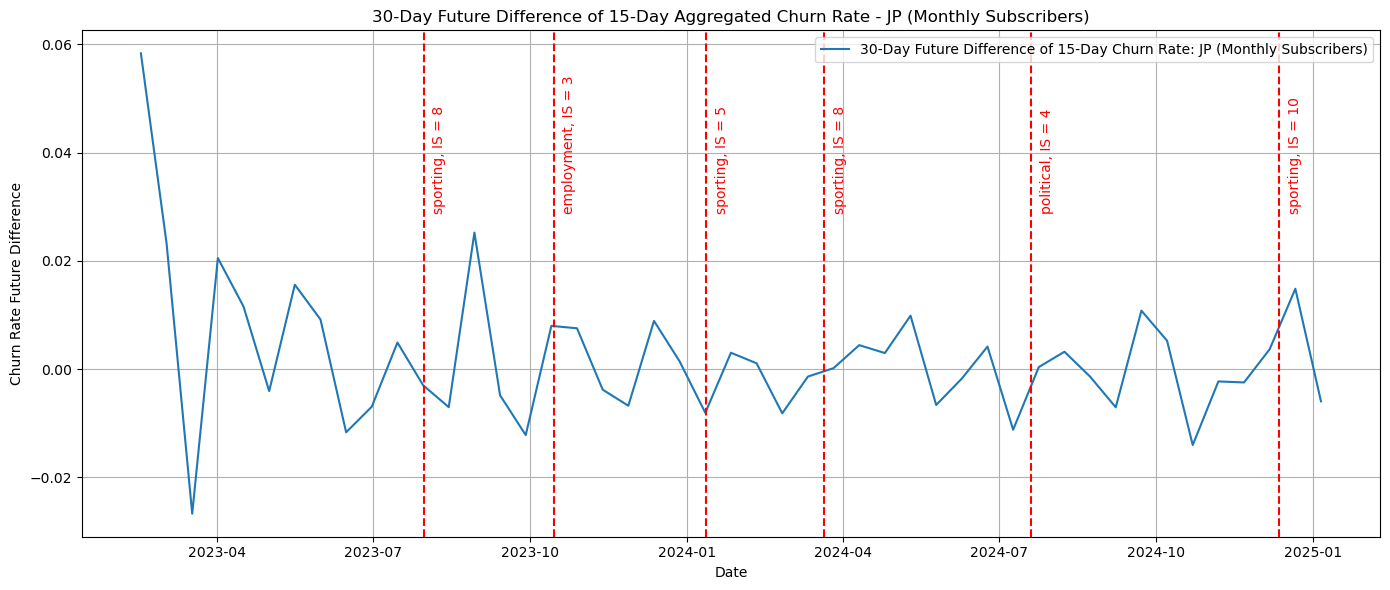

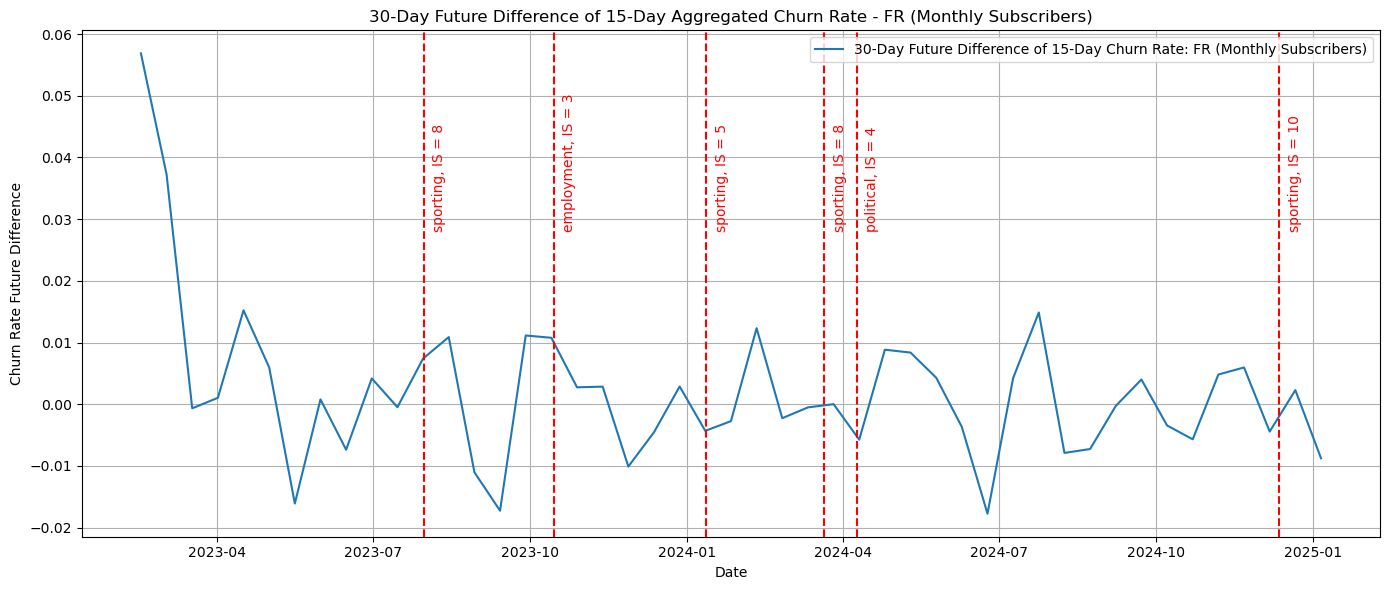

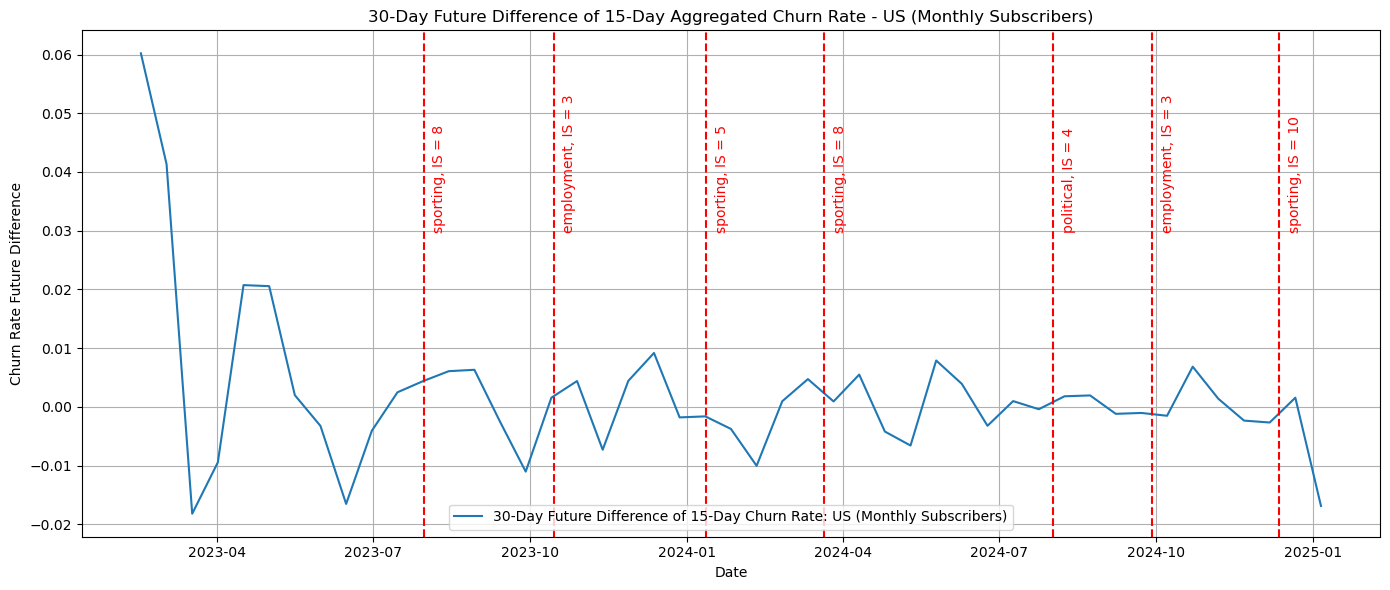

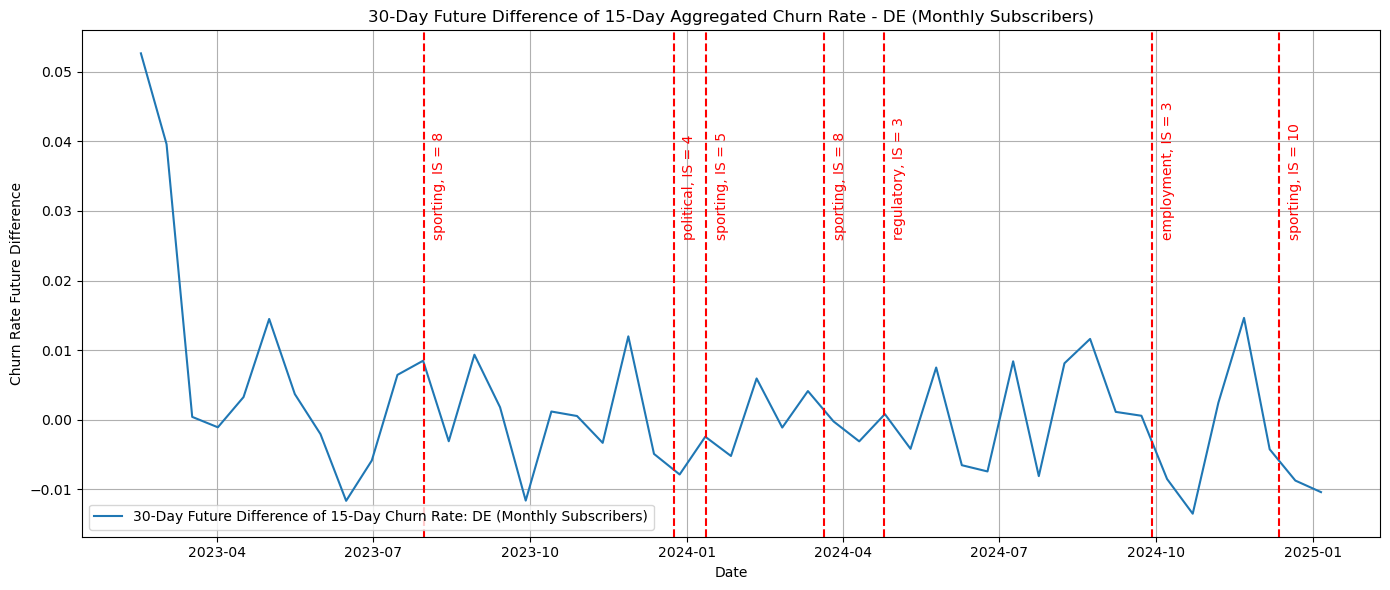

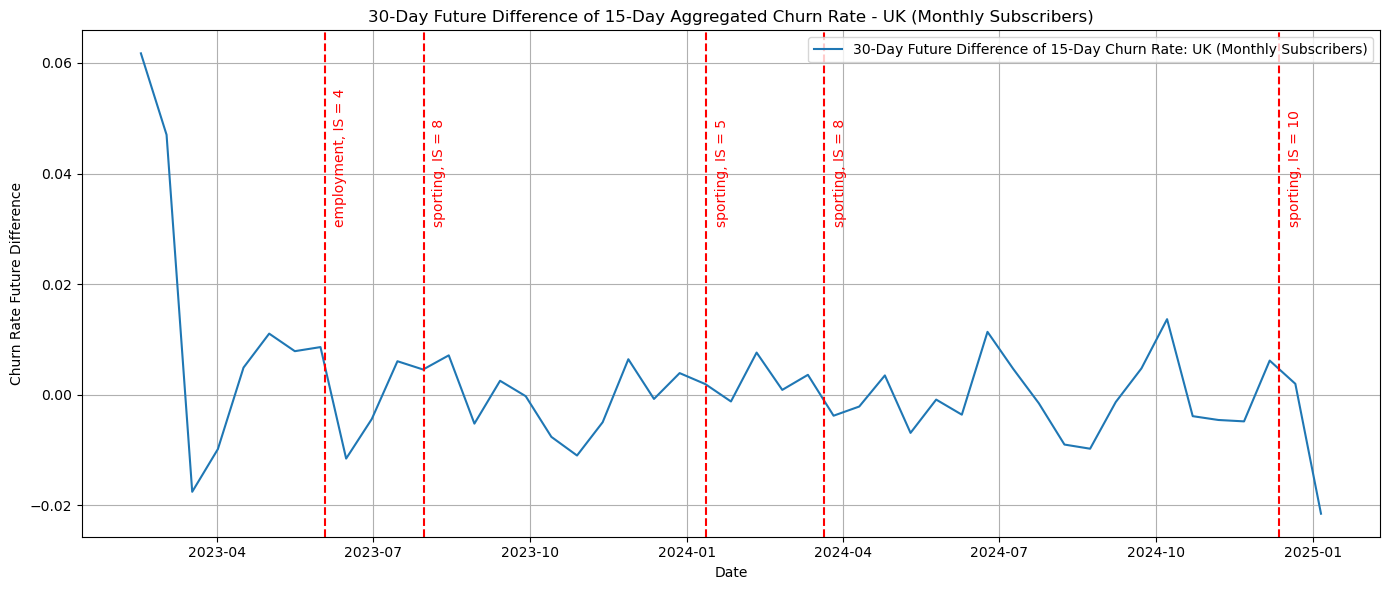

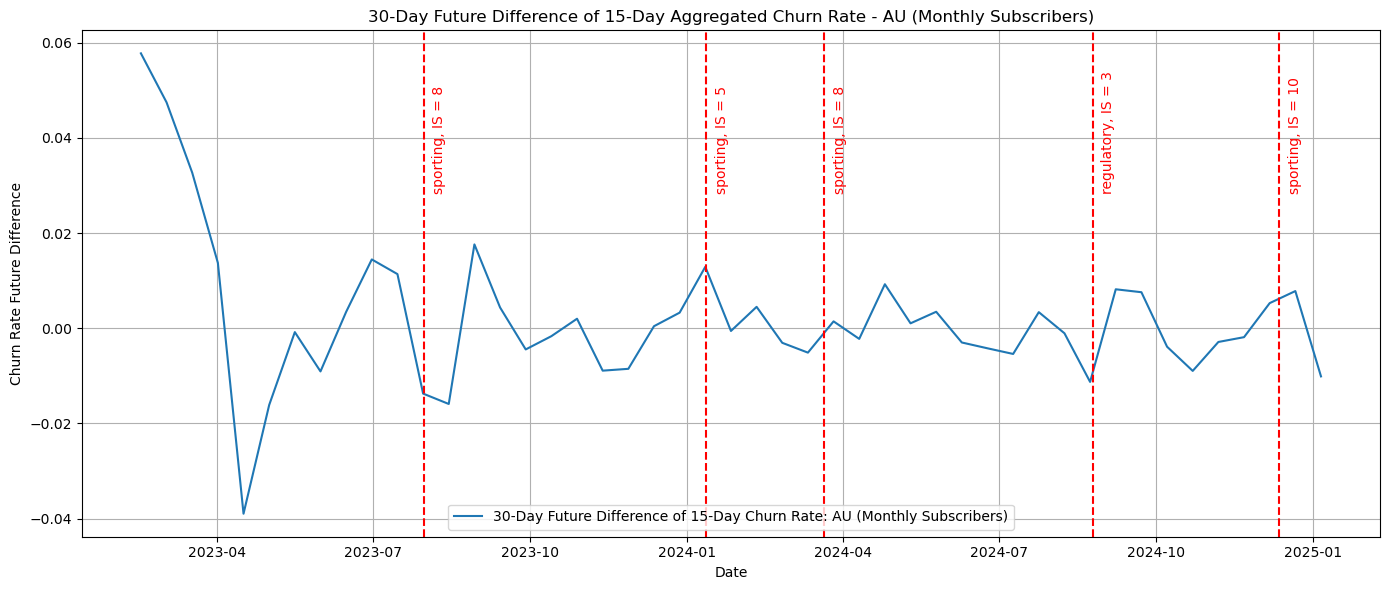

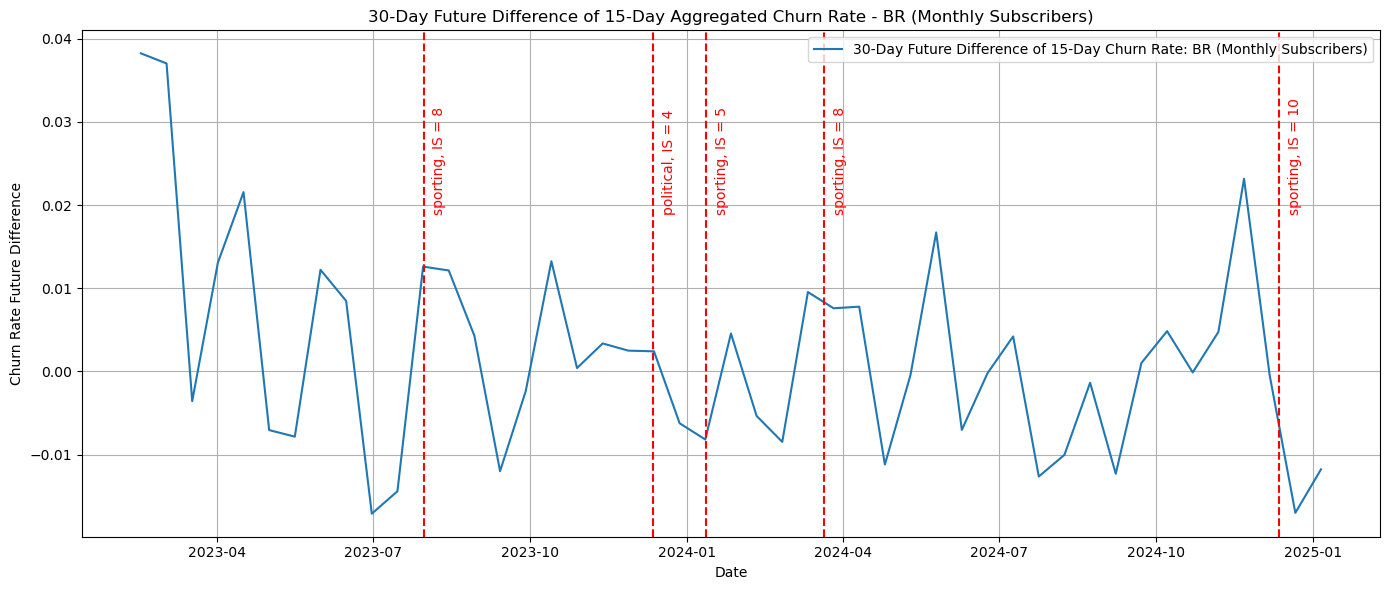

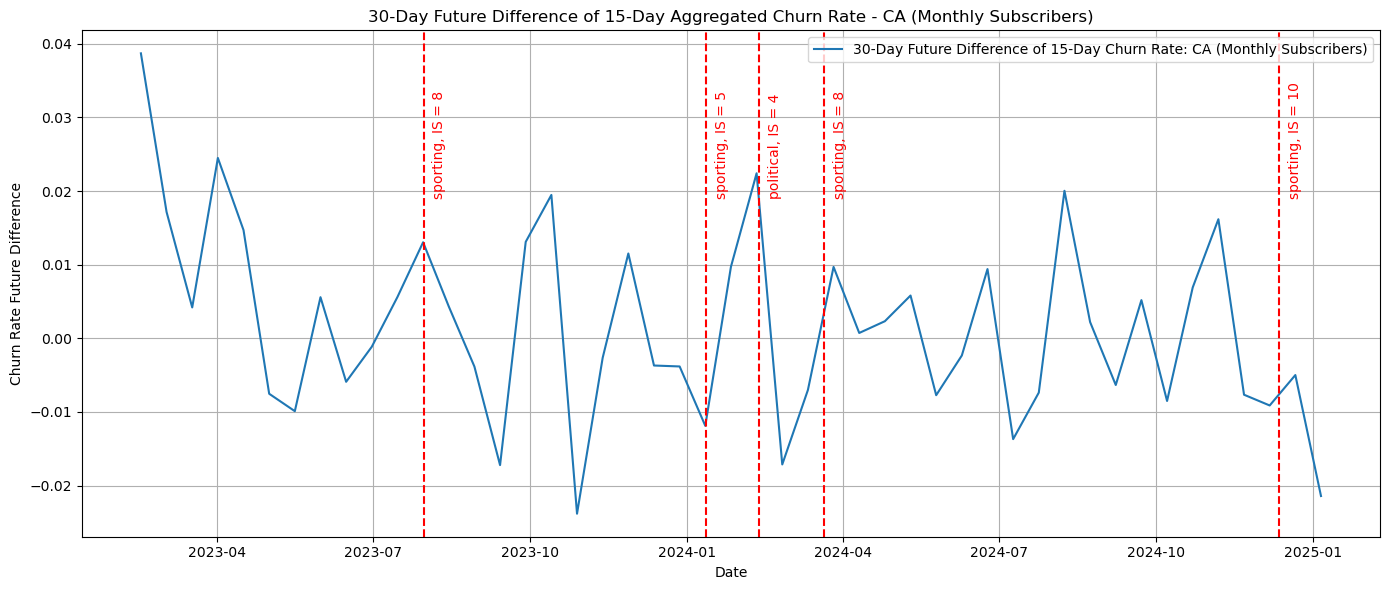

In [9]:
countries_with_events = event_data['country'].unique()
countries_with_events = [c for c in countries_with_events if c != 'global']
window_span = 15  # days per bin
window_shift = 30  # days between compared bins

for country in countries_with_events:
    country_users = merged_df[(merged_df['signup_country'] == country) & (merged_df['plan'] == 'monthly')]
    if country_users.empty:
        print(f"Skipping {country} as no monthly subscriber data available.")
        continue
    
    start_date = country_users['signup_date'].min()
    end_date = country_users['churn_date'].max()
    if pd.isna(start_date) or pd.isna(end_date):
        print(f"Skipping {country} due to missing dates.")
        continue

    bins = pd.date_range(start=start_date, end=end_date + pd.Timedelta(days=window_span), freq=f'{window_span}D')
    
    churn_rates = []
    bin_centers = []
    
    for i in range(len(bins) - 1):
        bin_start = bins[i]
        bin_end = bins[i+1]
        
        active_users = country_users[
            (country_users['signup_date'] < bin_start) &
            ((country_users['churn_date'].isna()) | (country_users['churn_date'] >= bin_start))
        ].shape[0]
        
        churned_users = country_users[
            (country_users['churn_date'] >= bin_start) & (country_users['churn_date'] < bin_end)
        ].shape[0]
        
        churn_rate = churned_users / active_users if active_users > 0 else 0
        churn_rates.append(churn_rate)
        bin_centers.append(bin_start + pd.Timedelta(days=window_span/2))

    churn_series = pd.Series(churn_rates, index=bin_centers)
    churn_diff = churn_series.shift(-2) - churn_series

    plt.figure(figsize=(14,6))
    plt.plot(churn_diff.index, churn_diff.values, label=f'30-Day Future Difference of 15-Day Churn Rate: {country} (Monthly Subscribers)')
    
    relevant_events = event_data[(event_data['country'] == country) | (event_data['country'] == 'global')]
    for _, event in relevant_events.iterrows():
        plt.axvline(event['date'], color='red', linestyle='--')
        plt.text(event['date']+ pd.Timedelta(days=5),
                 max(churn_diff.dropna())*0.5, 
                 f"{event['event_type']}, IS = {event['impact_score']}", 
                 rotation=90, 
                 color='red')
    
    plt.title(f'30-Day Future Difference of 15-Day Aggregated Churn Rate - {country} (Monthly Subscribers)')
    plt.xlabel('Date')
    plt.ylabel('Churn Rate Future Difference')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    #plt.show()
    plt.savefig(f'15AggregatedChurnRate{country}MonthlySubscribers.png')

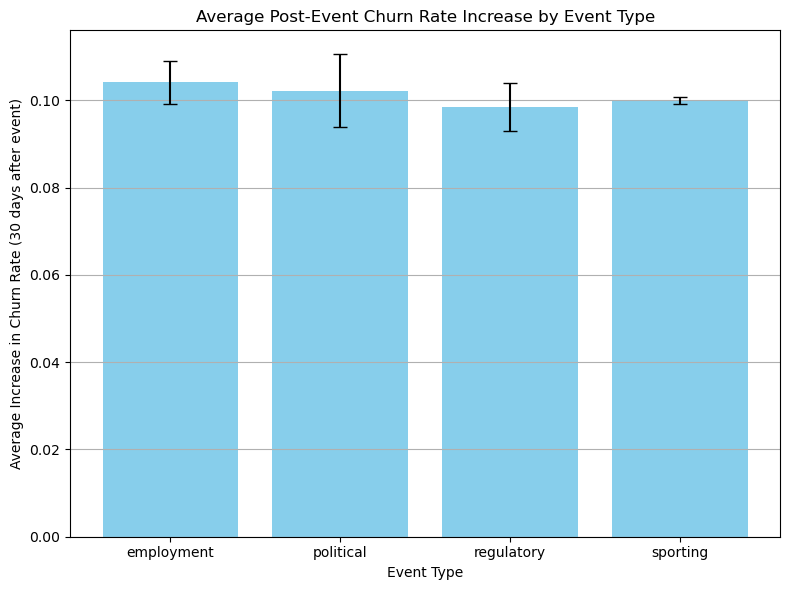

,event_type,mean,count,std
0,employment,0.104093,6,0.004969
1,political,0.102244,6,0.008269
2,regulatory,0.098462,2,0.005396
3,sporting,0.099984,4,0.000798


In [12]:

event_impacts_numeric=[]
for idx, event in event_data.iterrows():
    country = event['country']
    event_date = event['date']
    event_type = event['event_type']
    impact_score = event['impact_score']
    
    if country not in merged_df['signup_country'].unique() and country != 'global':
        continue
    
    if country == 'global':
        users = merged_df[merged_df['plan'] == 'monthly']
    else:
        users = merged_df[(merged_df['signup_country'] == country) & (merged_df['plan'] == 'monthly')]
    
    if users.empty:
        continue
    
    # Churn on event day
    active_on_event = users[(users['signup_date'] < event_date) & ((users['churn_date'].isna()) | (users['churn_date'] >= event_date))].shape[0]
    churn_on_event = users[users['churn_date'] == event_date].shape[0]
    churn_rate_event = churn_on_event / active_on_event if active_on_event > 0 else 0
    
    # Churn 1 to 30 days after event
    post_start = event_date + pd.Timedelta(days=1)
    post_end = event_date + pd.Timedelta(days=30)
    active_post = users[(users['signup_date'] < post_start) & ((users['churn_date'].isna()) | (users['churn_date'] >= post_start))].shape[0]
    churn_post = users[(users['churn_date'] >= post_start) & (users['churn_date'] <= post_end)].shape[0]
    churn_rate_post = churn_post / active_post if active_post > 0 else 0

    #Take the difference between post and event's churn rate
    churn_diff = churn_rate_post - churn_rate_event
    event_impacts_numeric.append({
        'country': country,
        'event_type': event_type,
        'impact_score': impact_score,
        'pre_churn_rate': churn_rate_event,
        'post_churn_rate': churn_rate_post,
        'churn_diff': churn_diff
    })

impacts_numeric_df = pd.DataFrame(event_impacts_numeric)

# Group by event type to see average churn impact
grouped_impact = impacts_numeric_df.groupby('event_type')['churn_diff'].agg(['mean', 'count', 'std']).reset_index()


plt.figure(figsize=(8,6))
plt.bar(
    grouped_impact['event_type'],
    grouped_impact['mean'],
    yerr=grouped_impact['std'],
    capsize=5,
    color='skyblue'
)
plt.xlabel('Event Type')
plt.ylabel('Average Increase in Churn Rate (30 days after event)')
plt.title('Average Post-Event Churn Rate Increase by Event Type')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("AveragePostEventChurn.png")
plt.show()

grouped_impact


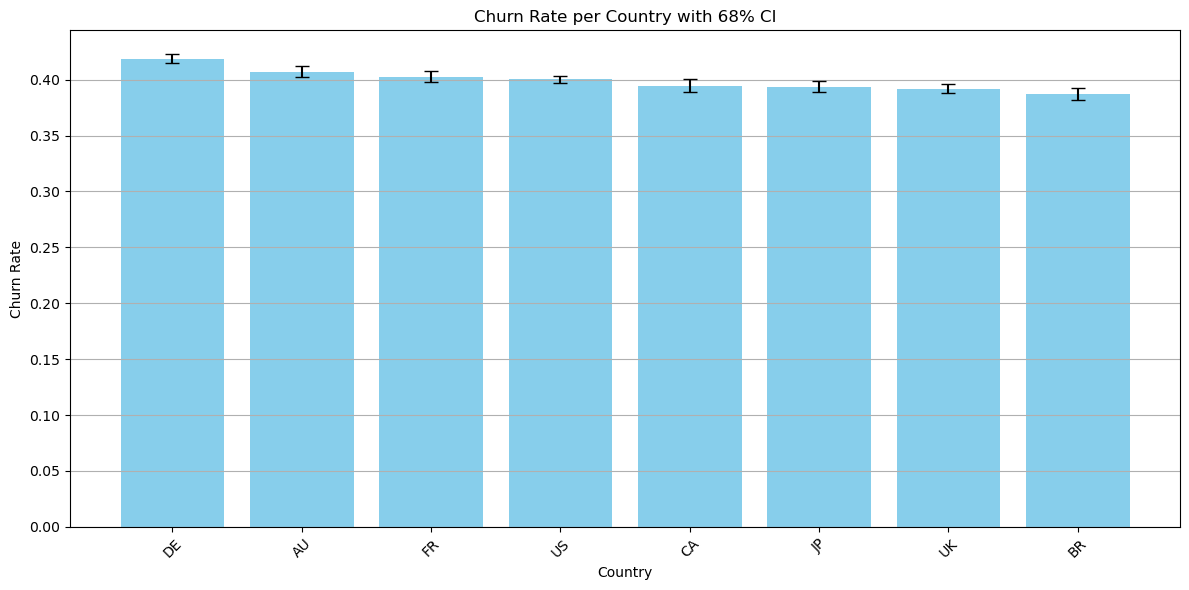

In [14]:
def get_68ci(p, n):
    se = np.sqrt(p * (1 - p) / n) if n > 0 else 0
    lower = max(0, p - se)
    upper = min(1, p + se)
    return lower, upper
merged_df['churn_flag'] = merged_df['isActive'].apply(lambda x: 0 if x == 1 else 1)

# --- Churn rate per country ---
country_counts = merged_df.groupby('signup_country')['churn_flag'].agg(['mean', 'count'])
country_counts['ci_lower'], country_counts['ci_upper'] = zip(*country_counts.apply(lambda row: get_68ci(row['mean'], row['count']), axis=1))
country_counts = country_counts.sort_values('mean', ascending=False)

plt.figure(figsize=(12,6))
plt.bar(country_counts.index, country_counts['mean'], 
        yerr=[country_counts['mean'] - country_counts['ci_lower'], country_counts['ci_upper'] - country_counts['mean']], 
        capsize=5, color='skyblue')
plt.title('Churn Rate per Country with 68% CI')
plt.ylabel('Churn Rate')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("churnrate_Vs_country.png")
plt.show()


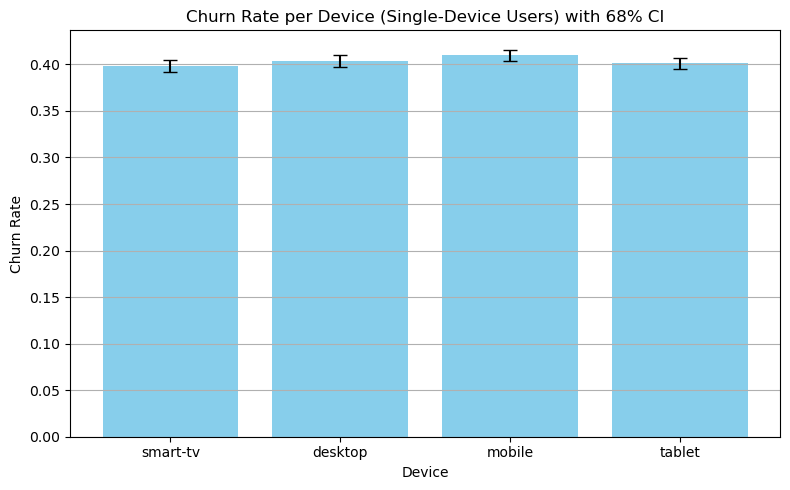

In [15]:
# Churn rate per device (single-device users)
# Filter single-device users

merged_df['num_devices'] = merged_df['devices_used'].apply(lambda x: len(x.split(",")))
single_device_df = merged_df[merged_df['num_devices'] == 1].copy()
single_device_df['single_device'] = single_device_df['devices_used'].apply(lambda x: x)

device_types = single_device_df['single_device'].unique()
#churn_device = single_device_df.groupby('single_device')['churn_flag'].mean().reindex(device_types)
device_counts = single_device_df.groupby('single_device')['churn_flag'].agg(['mean', 'count'])
device_counts['ci_lower'], device_counts['ci_upper'] = zip(*device_counts.apply(lambda row: get_68ci(row['mean'], row['count']), axis=1))
device_counts = device_counts.loc[device_types]  # keep order consistent

plt.figure(figsize=(8,5))
plt.bar(device_counts.index, device_counts['mean'], 
        yerr=[device_counts['mean'] - device_counts['ci_lower'], device_counts['ci_upper'] - device_counts['mean']], 
        capsize=5, color='skyblue')
plt.title('Churn Rate per Device (Single-Device Users) with 68% CI')
plt.ylabel('Churn Rate')
plt.xlabel('Device')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("churnrate_Vs_device.png")
plt.show()


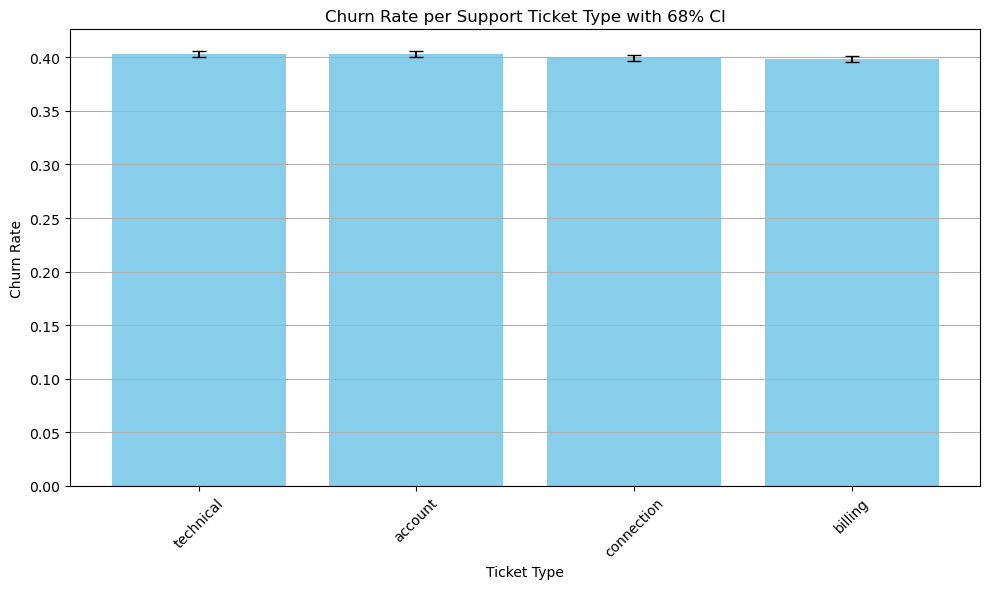

In [17]:

# Churn rate per support ticket type ---

merged_df['tickets_list'] = merged_df['support_tickets'].fillna('').apply(lambda x: [t.strip().lower() for t in x.split(',') if t.strip() != ''])
all_tickets = set()
merged_df['tickets_list'].apply(lambda x: all_tickets.update(x))
all_tickets = sorted(all_tickets)

ticket_stats = []
for ticket in all_tickets:
    users_with_ticket = merged_df[merged_df['tickets_list'].apply(lambda tickets: ticket in tickets)]
    n = len(users_with_ticket)
    p = users_with_ticket['churn_flag'].mean() if n > 0 else 0
    ci_lower, ci_upper = get_68ci(p, n)
    ticket_stats.append({'ticket': ticket, 'mean': p, 'count': n, 'ci_lower': ci_lower, 'ci_upper': ci_upper})

ticket_stats_df = pd.DataFrame(ticket_stats).sort_values('mean', ascending=False)

plt.figure(figsize=(10,6))
plt.bar(ticket_stats_df['ticket'], ticket_stats_df['mean'], 
        yerr=[ticket_stats_df['mean'] - ticket_stats_df['ci_lower'], ticket_stats_df['ci_upper'] - ticket_stats_df['mean']], 
        capsize=5, color='skyblue')
plt.title('Churn Rate per Support Ticket Type with 68% CI')
plt.ylabel('Churn Rate')
plt.xlabel('Ticket Type')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("churnrate_Vs_tickettype.png")

plt.show()



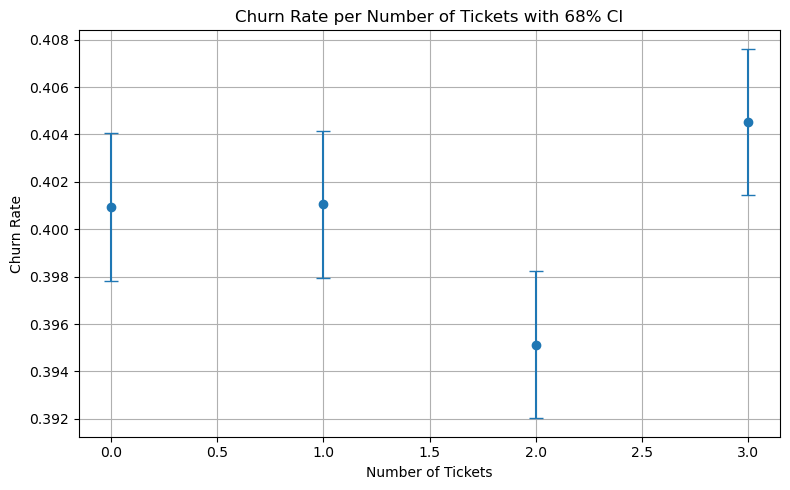

In [19]:
# Churn rate per N ticket
num_tickets_stats = merged_df.groupby('num_tickets')['churn_flag'].agg(['mean', 'count']).sort_index()
num_tickets_stats['ci_lower'], num_tickets_stats['ci_upper'] = zip(*num_tickets_stats.apply(lambda row: get_68ci(row['mean'], row['count']), axis=1))

plt.figure(figsize=(8,5))
plt.errorbar(num_tickets_stats.index, num_tickets_stats['mean'], 
             yerr=[num_tickets_stats['mean'] - num_tickets_stats['ci_lower'], num_tickets_stats['ci_upper'] - num_tickets_stats['mean']], 
             fmt='o', capsize=5)
plt.title('Churn Rate per Number of Tickets with 68% CI')
plt.xlabel('Number of Tickets')
plt.ylabel('Churn Rate')
plt.grid(True)
plt.tight_layout()
plt.savefig("churnrate_Vs_tickets.png")

plt.show()

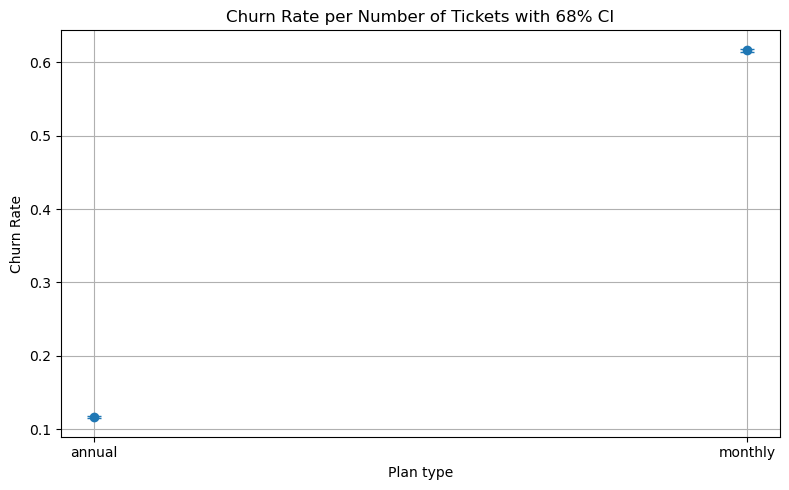

,mean,count,ci_lower,ci_upper
plan,,,,
annual,0.116720,43189,0.115175,0.118265
monthly,0.616113,56811,0.614073,0.618153


In [20]:
# Churn rate per Plan type
num_tickets_stats = merged_df.groupby('plan')['churn_flag'].agg(['mean', 'count']).sort_index()
num_tickets_stats['ci_lower'], num_tickets_stats['ci_upper'] = zip(*num_tickets_stats.apply(lambda row: get_68ci(row['mean'], row['count']), axis=1))

plt.figure(figsize=(8,5))
plt.errorbar(num_tickets_stats.index, num_tickets_stats['mean'], 
             yerr=[num_tickets_stats['mean'] - num_tickets_stats['ci_lower'], num_tickets_stats['ci_upper'] - num_tickets_stats['mean']], 
             fmt='o', capsize=5)
plt.title('Churn Rate per Number of Tickets with 68% CI')
plt.xlabel('Plan type')
plt.ylabel('Churn Rate')
plt.grid(True)
plt.tight_layout()
plt.savefig("churnrate_Vs_PlanType")
plt.show()

num_tickets_stats

/tmp/xpython_42/1517946746.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  usage_stats = merged_df.groupby('usage_hours_bin')['churn_flag'].agg(['mean', 'count']).sort_index()


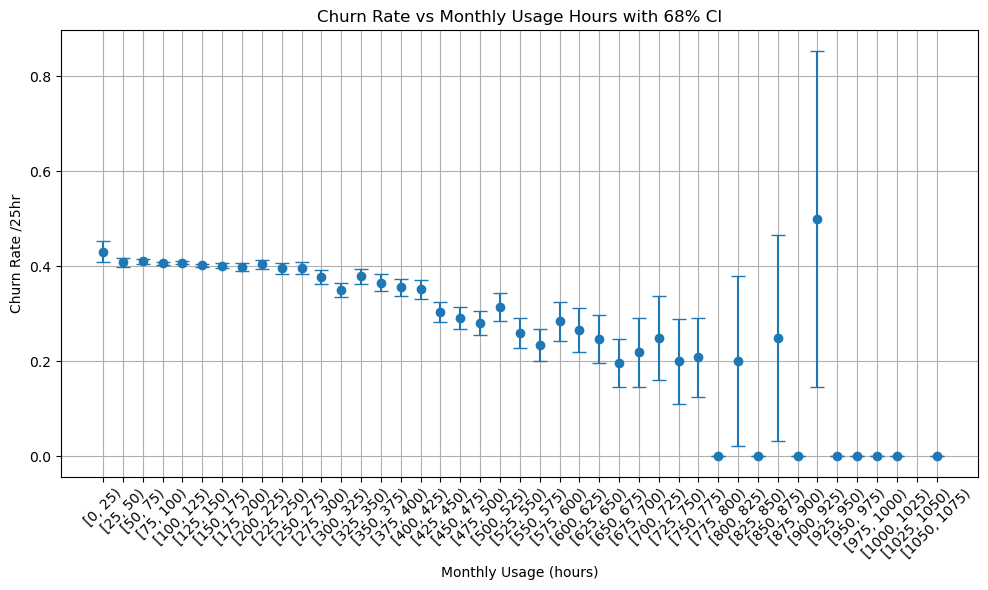

In [27]:
# Churn rate per monthly_usage_hours  
bin_width = 25
bins = np.arange(0, merged_df['monthly_usage_hours'].max() + bin_width, bin_width)

# Create binned column
merged_df['usage_hours_bin'] = pd.cut(merged_df['monthly_usage_hours'], bins=bins, right=False)
usage_stats = merged_df.groupby('usage_hours_bin')['churn_flag'].agg(['mean', 'count']).sort_index()
usage_stats['ci_lower'], usage_stats['ci_upper'] = zip(*usage_stats.apply(lambda row: get_68ci(row['mean'], row['count']), axis=1))

plt.figure(figsize=(10,6))
plt.errorbar(
    usage_stats.index.astype(str), usage_stats['mean'], 
    yerr=[usage_stats['mean'] - usage_stats['ci_lower'], usage_stats['ci_upper'] - usage_stats['mean']], 
    fmt='o', capsize=5
)
plt.title('Churn Rate vs Monthly Usage Hours with 68% CI')
plt.xlabel('Monthly Usage (hours)')
plt.ylabel('Churn Rate /25hr')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig("churnrate_vs_monthly_usage_hours.png")
plt.show()